Testing: 0 / 30
0.5724293073511959


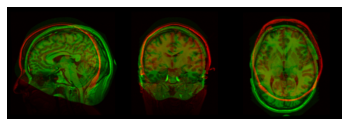

0.5724293073511959
0.5767830687665396


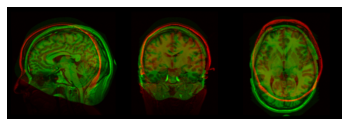

0.5767830687665396
0.5810121628545808


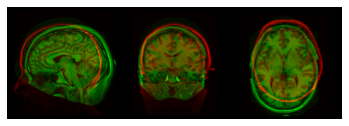

0.5810121628545808
0.5852136608712779


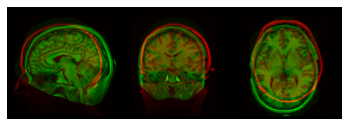

0.5852136608712779
0.5894717947956182


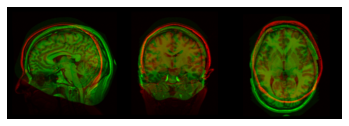

0.5894717947956182
0.5938447726022928


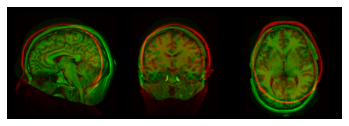

0.5938447726022928
0.5975570467907759


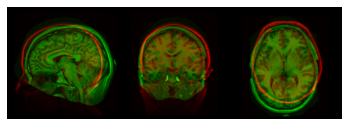

0.5975570467907759
0.6023475742399211


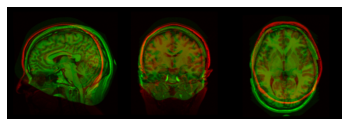

0.6023475742399211
0.6071859607947777


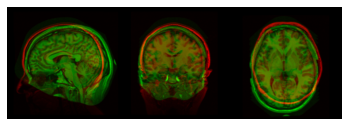

0.6071859607947777
0.6119393106428035


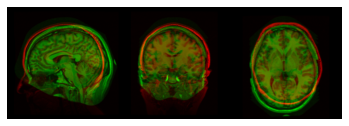

0.6119393106428035
0.616179592484644


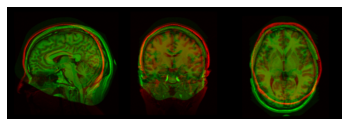

0.616179592484644
0.6212899373951946


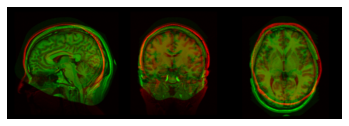

0.6212899373951946
0.6264405127332806


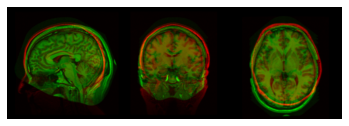

0.6264405127332806
0.6310735838135546


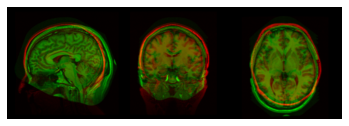

0.6310735838135546
0.6369000782078746


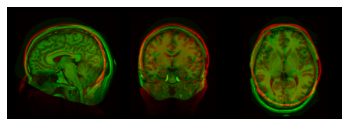

0.6369000782078746
0.6428877114665217


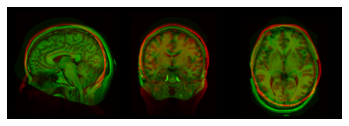

0.6428877114665217
0.6477177480783555


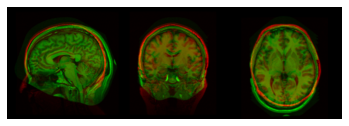

0.6477177480783555
0.6540867895169988


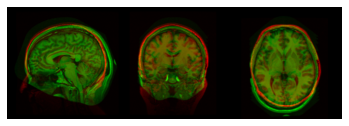

0.6540867895169988
0.6580422092041261


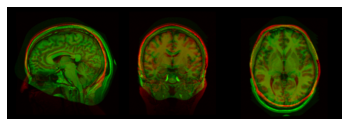

0.6580422092041261
0.6645221402641617


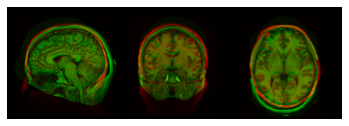

0.6645221402641617
0.6708980133771816


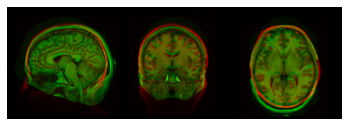

0.6708980133771816
0.6736333257796692


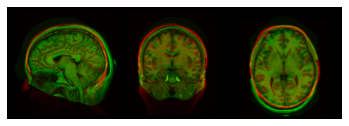

0.6736333257796692
0.6800197300580781


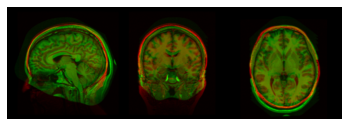

0.6800197300580781
0.6809560285920356


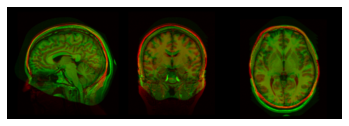

0.6809560285920356
0.6870180904809441


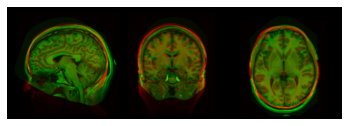

0.6870180904809441
0.6930387273980388


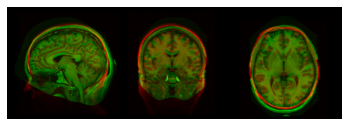

0.6930387273980388
0.690935451194656


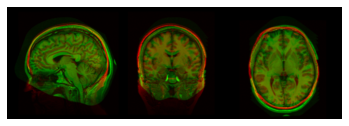

0.690935451194656
0.6966536471202603


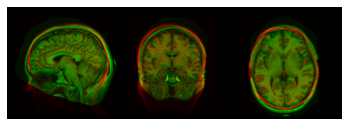

0.6966536471202603
0.7026283717797737


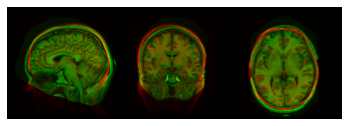

0.7026283717797737
0.7066135481409097


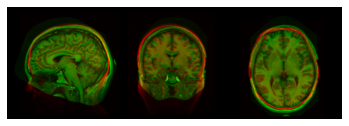

0.7066135481409097
0.7066135481409097


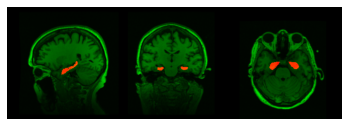

Best correlation:  0.7066135481409097
Avarage:  0.023553784938030325
Test Actions
[7, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [2]:
import gym
!pip install SimpleITK
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from gym import spaces
from gym.utils import seeding
from scipy import stats
import cv2
import glob
from random import randint
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import math
from keras.models import load_model
import tensorflow as tf 
from scipy import ndimage

#constants for transformations
movementOffset = 1
resizeValuePlus = 0.995
resizeValueMinus = 1.005
degrees = 1

actionHistogram = [0] * 18
actionHistogramPerVolume = [0] * 18
TESTSTEPS = 30

MODEL_PATH = 'drive/My Drive/model/model_final.h5'
ATLAS_PATH = 'drive/My Drive/atlas/atlas.nii'
TRAIN_DIRECTORY = "drive/My Drive/data_train_32bit/[0-9]*.nii"
TEST_DIRECTORY = "drive/My Drive/data_test_32bit/[0-9]*.nii"

class Agent:

    def __init__(self, stateShape, numberOfActions):
        self.stateShape = stateShape
        self.numberOfActions = numberOfActions

        self.neuralnetwork = AgentsNeuralNetwork(stateShape, numberOfActions)

    def actDeterministic(self, state):
        state = state.reshape((1, 256, 256, 256, 2))
        q = self.neuralnetwork.predictOne(state)
        return np.argmax(q)

class AgentsNeuralNetwork:

    def __init__(self, stateShape, numberOfActions):
        self.stateShape = stateShape
        self.numberOfActions = numberOfActions

        self.model = tf.keras.models.load_model(MODEL_PATH)

    def predictOne(self, state):
        return self.model.predict(state).flatten()
        
class RegistrationEnvironment(gym.Env):
    
    def __init__(self):
        self.maxSteps = 30
        self.shape = (256, 256, 256, 2)
        self.action_space = spaces.Discrete(18)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, 
                                            shape=self.shape, dtype=np.float64)
        self.volume = None
        self.sitk_volume = None
        self.atlas = self.LoadAtlas("drive/My Drive/atlas/atlas.nii")
        self.bestCorrelation = 0.0
        self.stepNumber = 0
        self.affineList = []
        self.listFileNames = []
        self.basicImage = None
        self.bestCorrelationIndex = 0
        self.target_update_counter = 0

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
        
    def step(self, action, index):
                  
        self.stepNumber = self.stepNumber + 1
    
        reward = 0.0
        done = False
        state = np.empty(self.shape)

        if (self.stepNumber == self.maxSteps):
            done = True
        else:
            if (action == 0):
                self.sitk_volume = self.movementCoordinateXUp(movementOffset)
            elif (action == 1):
                self.sitk_volume = self.movementCoordinateYUp(movementOffset)
            elif (action == 2):
                self.sitk_volume = self.movementCoordinateZUp(movementOffset)
            elif (action == 3):
                self.sitk_volume = self.movementCoordinateXDown(movementOffset)
            elif (action == 4):
                self.sitk_volume = self.movementCoordinateYDown(movementOffset)
            elif (action == 5):
                self.sitk_volume = self.movementCoordinateZDown(movementOffset)
            elif (action == 6):
                self.sitk_volume = self.rotateCoordinateXRight(degrees)
            elif (action == 7):
                self.sitk_volume = self.rotateCoordinateYRight(degrees)
            elif (action == 8):
                self.sitk_volume = self.rotateCoordinateZRight(degrees)
            elif (action == 9):
                self.sitk_volume = self.rotateCoordinateXLeft(degrees)
            elif (action == 10):
                self.sitk_volume = self.rotateCoordinateYLeft(degrees)
            elif (action == 11):
                self.sitk_volume = self.rotateCoordinateZLeft(degrees)
            elif (action == 12):
                self.sitk_volume = self.resizing(resizeValuePlus,1,1)
            elif (action == 13):
                self.sitk_volume = self.resizing(resizeValueMinus,1,1)
            elif (action == 14):
                self.sitk_volume = self.resizing(1,resizeValuePlus,1)
            elif (action == 15):
                self.sitk_volume = self.resizing(1,resizeValueMinus,1)
            elif (action == 16):
                self.sitk_volume = self.resizing(1,1,resizeValuePlus)
            elif (action == 17):
                self.sitk_volume = self.resizing(1,1,resizeValueMinus)
            else:
                pass

        corrActual = self.GetCorrelationCoeff(self.GetState())
        self.volume = sitk.GetArrayFromImage(self.sitk_volume)
        self.volume = self.normalize(self.volume)
        
        reward = self.GetReward(index, corrActual, action)      
        state = self.GetState() 
        return state, reward, done, {}
    
    def render(self, mode='human'):
        data = self.GetState()
        
        #axial view
        slice00 = data[:, :, :, 0]
        slice00 = slice00[slice00.shape[0]//2,:,:] 
        slice00 = (slice00 - slice00.min()) / (slice00.max() - slice00.min())
        slice10 = data[:, :, :, 1]
        slice10 = slice10[slice10.shape[0]//2,:,:]
        slice10 = (slice10 - slice10.min()) / (slice10.max() - slice10.min())
        
        #coronal view
        slice01 = data[:, :, :, 0]
        slice01 = slice01[:,slice01.shape[1]//2,:]
        slice01 = (slice01 - slice01.min()) / (slice01.max() - slice01.min())
        slice11 = data[:, :, :, 1]
        slice11 = slice11[:,slice11.shape[1]//2,:]
        slice11 = (slice11 - slice11.min()) / (slice11.max() - slice11.min())
        
        #sagittal view
        slice02 = data[:, :, :, 0]
        slice02 = slice02[:,:,slice02.shape[2]//2]
        slice02 = (slice02 - slice02.min()) / (slice02.max() - slice02.min())
        slice12 = data[:, :, :, 1]
        slice12 = slice12[:,:,slice12.shape[2]//2]
        slice12 = (slice12 - slice12.min()) / (slice12.max() - slice12.min())
        
        temp0 = np.zeros((slice00.shape), dtype=np.float32)
        temp1 = np.zeros((slice01.shape), dtype=np.float32)
        temp2 = np.zeros((slice02.shape), dtype=np.float32)
        merge0 = cv2.merge((slice00,slice10,temp0))
        merge1 = cv2.merge((slice01,slice11,temp1))
        merge2 = cv2.merge((slice02,slice12,temp2))
        finalImage = np.concatenate((merge0, merge1, merge2), axis=1)
        finalImage = ndimage.rotate(finalImage, 180)
        plt.imshow((finalImage * 255).astype(np.uint8))
        plt.axis('off')
        plt.show()     
    
    def renderSegment(self, data, axial, coronal, sagittal, mode='human'):
        #axial view
        slice00 = data[:, :, :, 0]
        slice00 = slice00[axial,:,:] 
        slice00 = (slice00 - slice00.min()) / (slice00.max() - slice00.min())
        slice10 = data[:, :, :, 1]
        slice10 = slice10[axial,:,:]
        slice10 = (slice10 - slice10.min()) / (slice10.max() - slice10.min())
        
        #coronal view
        slice01 = data[:, :, :, 0]
        slice01 = slice01[:,coronal,:]
        slice01 = (slice01 - slice01.min()) / (slice01.max() - slice01.min())
        slice11 = data[:, :, :, 1]
        slice11 = slice11[:,coronal,:]
        slice11 = (slice11 - slice11.min()) / (slice11.max() - slice11.min())
        
        #sagittal view
        slice02 = data[:, :, :, 0]
        slice02 = slice02[:,:,sagittal]
        slice02 = (slice02 - slice02.min()) / (slice02.max() - slice02.min())
        slice12 = data[:, :, :, 1]
        slice12 = slice12[:,:,sagittal]
        slice12 = (slice12 - slice12.min()) / (slice12.max() - slice12.min())
              
        temp0 = np.zeros((slice00.shape), dtype=np.float32)
        temp1 = np.zeros((slice01.shape), dtype=np.float32)
        temp2 = np.zeros((slice02.shape), dtype=np.float32)
        merge0 = cv2.merge((slice00,slice10,temp0))
        merge1 = cv2.merge((slice01,slice11,temp1))
        merge2 = cv2.merge((slice02,slice12,temp2))
        finalImage = np.concatenate((merge0, merge1, merge2), axis=1)
        finalImage = ndimage.rotate(finalImage, 180)
        plt.imshow((finalImage * 255).astype(np.uint8))
        plt.axis('off')
        plt.show()     

    def reset(self):
        self.stepNumber = 0
        self.affineList = []
        self.listFileNames = glob.glob(TRAIN_DIRECTORY)
        randomNumber = randint(0, 60)
        self.volume = self.LoadVolume(self.listFileNames[randomNumber])
        self.bestCorrelation = self.GetCorrelationCoeff(self.GetState())
        return self.GetState()

    def resetTest(self,counter):
        self.stepNumber = 0
        self.affineList = []
        self.listFileNames = glob.glob(TEST_DIRECTORY)
        self.volume = self.LoadVolume(self.listFileNames[counter])
        self.bestCorrelation = self.GetCorrelationCoeff(self.GetState())
        return self.GetState()

    def close(self):
        pass
    
    #normalize data - subtract mean, divide by standard deviation
    def normalize(self, vectorizedVolume):
        mean = np.mean(vectorizedVolume)
        std = np.std(vectorizedVolume)
        vectorizedVolume = (vectorizedVolume - mean) / std
        return vectorizedVolume
    
    #atlas of size (256, 256, 256)
    def LoadAtlas(self, path):
        sitk_atlas = sitk.ReadImage(path)
        vectorizedVolume = sitk.GetArrayFromImage(sitk_atlas)
        vectorizedVolume = self.normalize(vectorizedVolume)
        return vectorizedVolume
    
    def LoadVolume(self, path):
        self.sitk_volume = sitk.ReadImage(path)
        self.basicImage = self.sitk_volume 
        vectorizedVolume = sitk.GetArrayFromImage(self.sitk_volume)
        vectorizedVolume = self.normalize(vectorizedVolume)
        return vectorizedVolume

    def GetState(self):
        state = np.empty(self.shape)
        volume1 = self.volume
        volume2 = self.atlas
        state = np.stack([volume1, volume2], axis=3)
        return state
    
    def GetCorrelationCoeff(self, state):
        correlation = np.corrcoef(state[:, :, :, 0].reshape(-1), 
                                  state[:, :, :, 1].reshape(-1))[0,1]
        
        print(correlation)

        return correlation
    
    def GetReward(self, index, corrActual, action):
        data = self.GetState()
        futureCorrelation = self.GetCorrelationCoeff(data)
        retval = futureCorrelation - corrActual
    
        if (futureCorrelation > self.bestCorrelation):
            self.bestCorrelation = futureCorrelation
            self.bestCorrelationIndex = index
            actionHistogram[action] += 1
            actionHistogramPerVolume[action] += 1

        return retval
    
    def compositeTransform(self):
        composite = sitk.Transform(3, sitk.sitkComposite)
        
        for i in self.affineList:
            composite.AddTransform(i)

        return self.resample(composite)
    
    def compositeTransformBestCorrelation(self):
        composite = sitk.Transform(3, sitk.sitkComposite)
        counter = 0
       
        for i in self.affineList:
            composite.AddTransform(i)
            if (counter == self.bestCorrelationIndex):
                break
            counter += 1

        return self.resample(composite)

    def resample(self, transform):
        reference_image = self.basicImage
        interpolator = sitk.sitkLinear
        default_value = 0.0
        return sitk.Resample(self.basicImage, reference_image, transform,
                             interpolator, default_value)
        
    def movementCoordinateXUp(self, value):
        affine = sitk.AffineTransform(3)
        affine.SetTranslation((-value, 0.0, 0.0))
        self.affineList.append(affine)
        return self.compositeTransform()
    
    def movementCoordinateXDown(self, value):
        affine = sitk.AffineTransform(3)
        affine.SetTranslation((value, 0.0, 0.0))
        self.affineList.append(affine)
        return self.compositeTransform()
    
    def movementCoordinateYUp(self, value):
        affine = sitk.AffineTransform(3)
        affine.SetTranslation((0.0, -value, 0.0))
        self.affineList.append(affine)
        return self.compositeTransform()
    
    def movementCoordinateYDown(self, value):
        affine = sitk.AffineTransform(3)
        affine.SetTranslation((0.0, value, 0.0))
        self.affineList.append(affine)
        return self.compositeTransform()
    
    def movementCoordinateZUp(self, value):
        affine = sitk.AffineTransform(3)
        affine.SetTranslation((0.0, 0.0, -value))
        self.affineList.append(affine)
        return self.compositeTransform()
    
    def movementCoordinateZDown(self, value):
        affine = sitk.AffineTransform(3)
        affine.SetTranslation((0.0, 0.0, value))
        self.affineList.append(affine)
        return self.compositeTransform()
    
    def resizing(self, value0, value1, value2):
        affine = sitk.AffineTransform(3)
        affine.Scale((value0, value1, value2))
        self.affineList.append(affine)
        return self.compositeTransform()
        
    #copied from https://stackoverflow.com/questions/56171643/simpleitk-rotation-of-mri-image
    def get_center(self, volume):
        width, height, depth = volume.GetSize()
        return volume.TransformIndexToPhysicalPoint((int(np.ceil(width/2)),
                                              int(np.ceil(height/2)),
                                              int(np.ceil(depth/2))))
        
    #copied from https://stackoverflow.com/questions/56171643/simpleitk-rotation-of-mri-image
    def rotation(self, theta_x, theta_y, theta_z):
        theta_x = np.deg2rad(theta_x)
        theta_y = np.deg2rad(theta_y)
        theta_z = np.deg2rad(theta_z)
        euler_transform = sitk.Euler3DTransform(self.get_center(self.sitk_volume), 
                                                theta_x, theta_y, 
                                                theta_z, (0, 0, 0))
        image_center = self.get_center(self.sitk_volume)
        euler_transform.SetCenter(image_center)
        euler_transform.SetRotation(theta_x, theta_y, theta_z)
        self.affineList.append(euler_transform)
       
    def rotateCoordinateXRight(self, degrees):
        self.rotation(degrees, 0, 0)
        return self.compositeTransform()
    
    def rotateCoordinateYRight(self, degrees):
        self.rotation(0, degrees, 0)
        return self.compositeTransform()
    
    def rotateCoordinateZRight(self, degrees):
        self.rotation(0, 0, degrees)  
        return self.compositeTransform()
    
    def rotateCoordinateXLeft(self, degrees):
        self.rotation(-degrees, 0, 0)
        return self.compositeTransform()
    
    def rotateCoordinateYLeft(self, degrees):
        self.rotation(0, -degrees, 0)
        return self.compositeTransform()
    
    def rotateCoordinateZLeft(self, degrees):
        self.rotation(0, 0, -degrees)  
        return self.compositeTransform()
    
    def getSegmentationMask(self, left, right):
        labels = sitk.ReadImage("drive/My Drive/atlas/atlas_labels.nii")
        vectorizedLabels = sitk.GetArrayFromImage(labels)

        for i in range(0,vectorizedLabels.shape[0]):
            for j in range(0,vectorizedLabels.shape[1]):
                for k in range(0,vectorizedLabels.shape[2]):
                    if (vectorizedLabels[i][j][k] == left or 
                        vectorizedLabels[i][j][k] == right):
                        vectorizedLabels[i][j][k] = 1.0
                    else:
                        vectorizedLabels[i][j][k] = 0.0

        return vectorizedLabels

    def segmentationFunction(self,param1, param2):
        mask = self.getSegmentationMask(param1,param2)
        volume = self.compositeTransformBestCorrelation()
        volume = sitk.GetArrayFromImage(volume)
        segmentData = np.empty(self.shape)
        segmentData = np.stack([mask, volume], axis=3)
        self.renderSegment(segmentData, 110, 110, 110)

    def test(self, agent, counter):
        state = self.resetTest(counter)
        index = 0
        actionHistogramPerVolume = [0] * 18
        
        for i in range(TESTSTEPS):            
            self.render()
            action = agent.actDeterministic(state)
       
            state, reward, done, info = self.step(action, index)        

            index += 1

        #print hippocampus, segment
        self.segmentationFunction(47,48)

        #get best corellation and add to list, i will count avarage of it
        return(self.bestCorrelation)
   
if __name__== "__main__":
    env = RegistrationEnvironment()
    stateShape  = env.observation_space.shape
    numberOfActions = env.action_space.n

    agent = Agent(stateShape, numberOfActions)

    numberOfTestData = glob.glob(TEST_DIRECTORY)
  
    correlations = np.tile(0.0, len(numberOfTestData))

    for i in range(0,1):
        print("Testing: " + str(i) + " / " + str(len(numberOfTestData)))
        correlations[i] = env.test(agent, 10)
        print("Best correlation: ", correlations[i])

    #avarage
    suma = 0
    for i in correlations:
        suma += i
    
    avarage = suma/len(correlations)
    print("Avarage: ", avarage)
    #print(correlations)
    print("Test Actions")
    print(actionHistogram)